<h1>Load Data</h1>

In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
train_file = "res/raw_data.csv"
header_file = "res/header.csv"

names = None
with open(header_file, 'r') as f:
    for l in f:
        names = l.strip('\n').split(',')
    names = names
    
train_data = pd.read_csv(train_file, names=names, low_memory=False)

In [50]:
train_data = train_data = train_data.iloc[1:]
train_data.head()

,ID,Flow.ID,Source.IP,Source.Port,Destination.IP,...,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
1,1651.0,172.217.29.66-10.200.7.196-443-39485-6,10.200.7.196,39485,172.217.29.66,...,0,0,BENIGN,64,SSL_NO_CERT
2,6460.0,179.1.4.244-10.200.7.196-443-43024-6,10.200.7.196,43024,179.1.4.244,...,0,0,BENIGN,64,SSL_NO_CERT
3,6578.0,179.1.4.244-10.200.7.196-443-43031-6,10.200.7.196,43031,179.1.4.244,...,0,0,BENIGN,64,SSL_NO_CERT
4,7219.0,179.1.4.244-10.200.7.196-443-43064-6,10.200.7.196,43064,179.1.4.244,...,0,0,BENIGN,64,SSL_NO_CERT
5,7683.0,179.1.4.244-10.200.7.196-443-43076-6,10.200.7.196,43076,179.1.4.244,...,0,0,BENIGN,64,SSL_NO_CERT


In [51]:
train_data.shape

(4317, 88)

<BarContainer object of 4 artists>

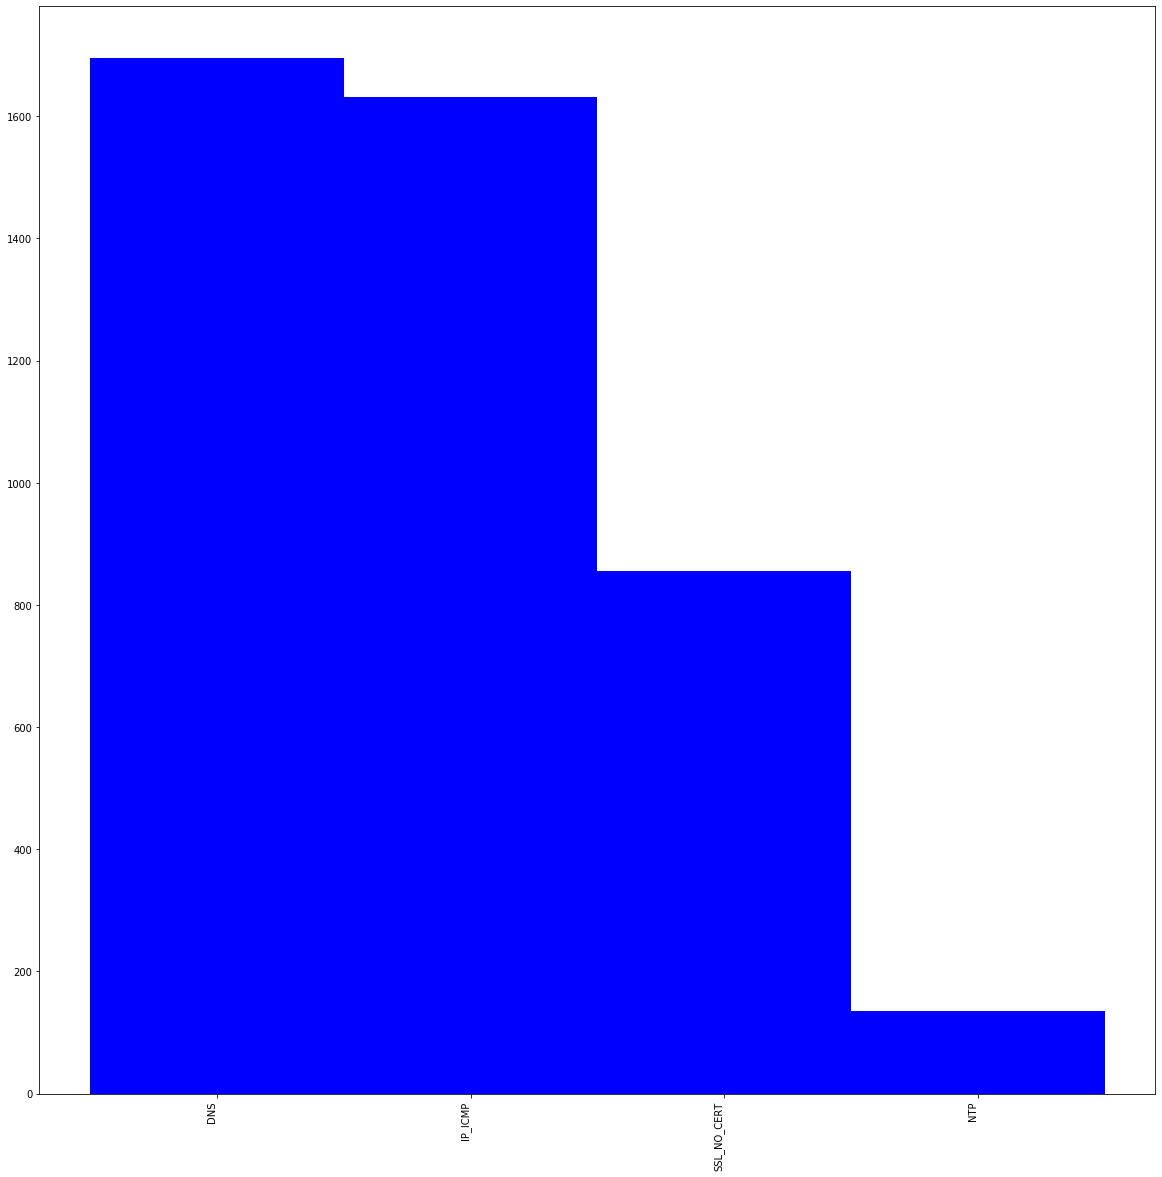

In [4]:
protocol_name = dict(train_data['ProtocolName'].value_counts())
plt.figure(figsize=(20,20))
plt.xticks(rotation=90, ha='right')
plt.bar(protocol_name.keys(), protocol_name.values(), width=1.0, color='b')

<h1> Data Transformation </h1>

In [5]:
# remove uesless attr.
# ID, flow id, timestamp, Label 
train_data.drop(['ID', 'Flow.ID', 'Timestamp', 'Label'], axis=1, inplace=True)

In [6]:
# private IP & public IP
import ipaddress 

In [7]:
srcIPPub = []
srcIPPri = []
for ip in train_data['Source.IP']:
    if ipaddress.ip_address(ip).is_private:
        srcIPPub.append(0)
        srcIPPri.append(1)
    else:
        srcIPPub.append(1)
        srcIPPri.append(0)

dstIPPub = []
dstIPPri = []
for ip in train_data['Destination.IP']:
    if ipaddress.ip_address(ip).is_private:
        dstIPPub.append(0)
        dstIPPri.append(1)
    else:
        dstIPPub.append(1)
        dstIPPri.append(0)

train_data['Dst.IP.Pub'] = dstIPPub
train_data['Src.IP.Pub'] = srcIPPri
train_data['Dst.IP.Pri'] = dstIPPub
train_data['Src.IP.Pri'] = srcIPPri

In [8]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
train_data.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,...,ProtocolName,Dst.IP.Pub,Src.IP.Pub,Dst.IP.Pri,Src.IP.Pri
1,10.200.7.196,39485,172.217.29.66,443,6,...,SSL_NO_CERT,1,1,1,1
2,10.200.7.196,43024,179.1.4.244,443,6,...,SSL_NO_CERT,1,1,1,1
3,10.200.7.196,43031,179.1.4.244,443,6,...,SSL_NO_CERT,1,1,1,1
4,10.200.7.196,43064,179.1.4.244,443,6,...,SSL_NO_CERT,1,1,1,1
5,10.200.7.196,43076,179.1.4.244,443,6,...,SSL_NO_CERT,1,1,1,1


In [9]:
sp = pd.DataFrame(train_data['Source.Port'].value_counts())
dp = pd.DataFrame(train_data['Destination.Port'].value_counts())
display(sp)
display(dp)

,Source.Port
0,1631
57429,254
59979,237
51242,225
54944,181
...,...
44365,1
59637,1
35791,1
54809,1


,Destination.Port
0,1631
53,1593
443,812
123,135
51242,40
...,...
46306,1
40068,1
36116,1
37746,1


<h1> Encoding </h1>

In [10]:
one_hot_src_map = {'0': [], '22': [], '21': [], '123': [], '53': [], '3128': [], '443': [], 'other_port':[]}
one_hot_dst_map = {'0': [], '22': [], '22': [], '123': [], '53': [], '3128': [], '443': [], 'other_port':[]}

l = train_data.shape[0]

for k in one_hot_src_map:
    one_hot_src_map[k] = [0]*l
    
for i, port in enumerate(train_data['Source.Port']):
    if str(port) in one_hot_src_map:
        one_hot_src_map[str(port)][i] = 1
    else:
        one_hot_src_map['other_port'][i] = 1

In [11]:
for k in one_hot_dst_map:
    one_hot_dst_map[k] = [0]*l
    
for i, port in enumerate(train_data['Destination.Port']):
    if str(port) in one_hot_dst_map:
        one_hot_dst_map[str(port)][i] = 1
    else:
        one_hot_dst_map['other_port'][i] = 1

In [12]:
for k in one_hot_src_map:
    train_data['src_port_' + k] = one_hot_src_map[k]

for k in one_hot_dst_map:
    train_data['dst_port_' + k] = one_hot_dst_map[k]

In [13]:
train_data.drop(['Source.Port', 'Source.IP', 'Destination.Port', 'Destination.IP'], axis=1, inplace=True)

In [14]:
train_data.head()

,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,...,dst_port_123,dst_port_53,dst_port_3128,dst_port_443,dst_port_other_port
1,6,2021337,9,5,795,...,0,0,0,1,0
2,6,65552,14,8,373,...,0,0,0,1,0
3,6,107032,14,12,373,...,0,0,0,1,0
4,6,75351,14,11,373,...,0,0,0,1,0
5,6,65862,15,13,373,...,0,0,0,1,0


In [15]:
train_data.shape

(4317, 99)

In [16]:
train_data['ProtocolName'] = train_data['ProtocolName'].astype('category')
cat_columns = train_data.select_dtypes(['category']).columns
train_label = train_data[cat_columns].apply(lambda x: x.cat.codes)

In [17]:
train_data.drop(['ProtocolName', 'L7Protocol'], axis=1, inplace=True)

<h1> Normalization </h1>

In [18]:
from sklearn.preprocessing import Normalizer
norm = Normalizer(norm='l2')

In [19]:
normalized_data = norm.fit_transform(train_data)

In [20]:
train_data_norm = pd.DataFrame(data=normalized_data, columns=train_data.columns)

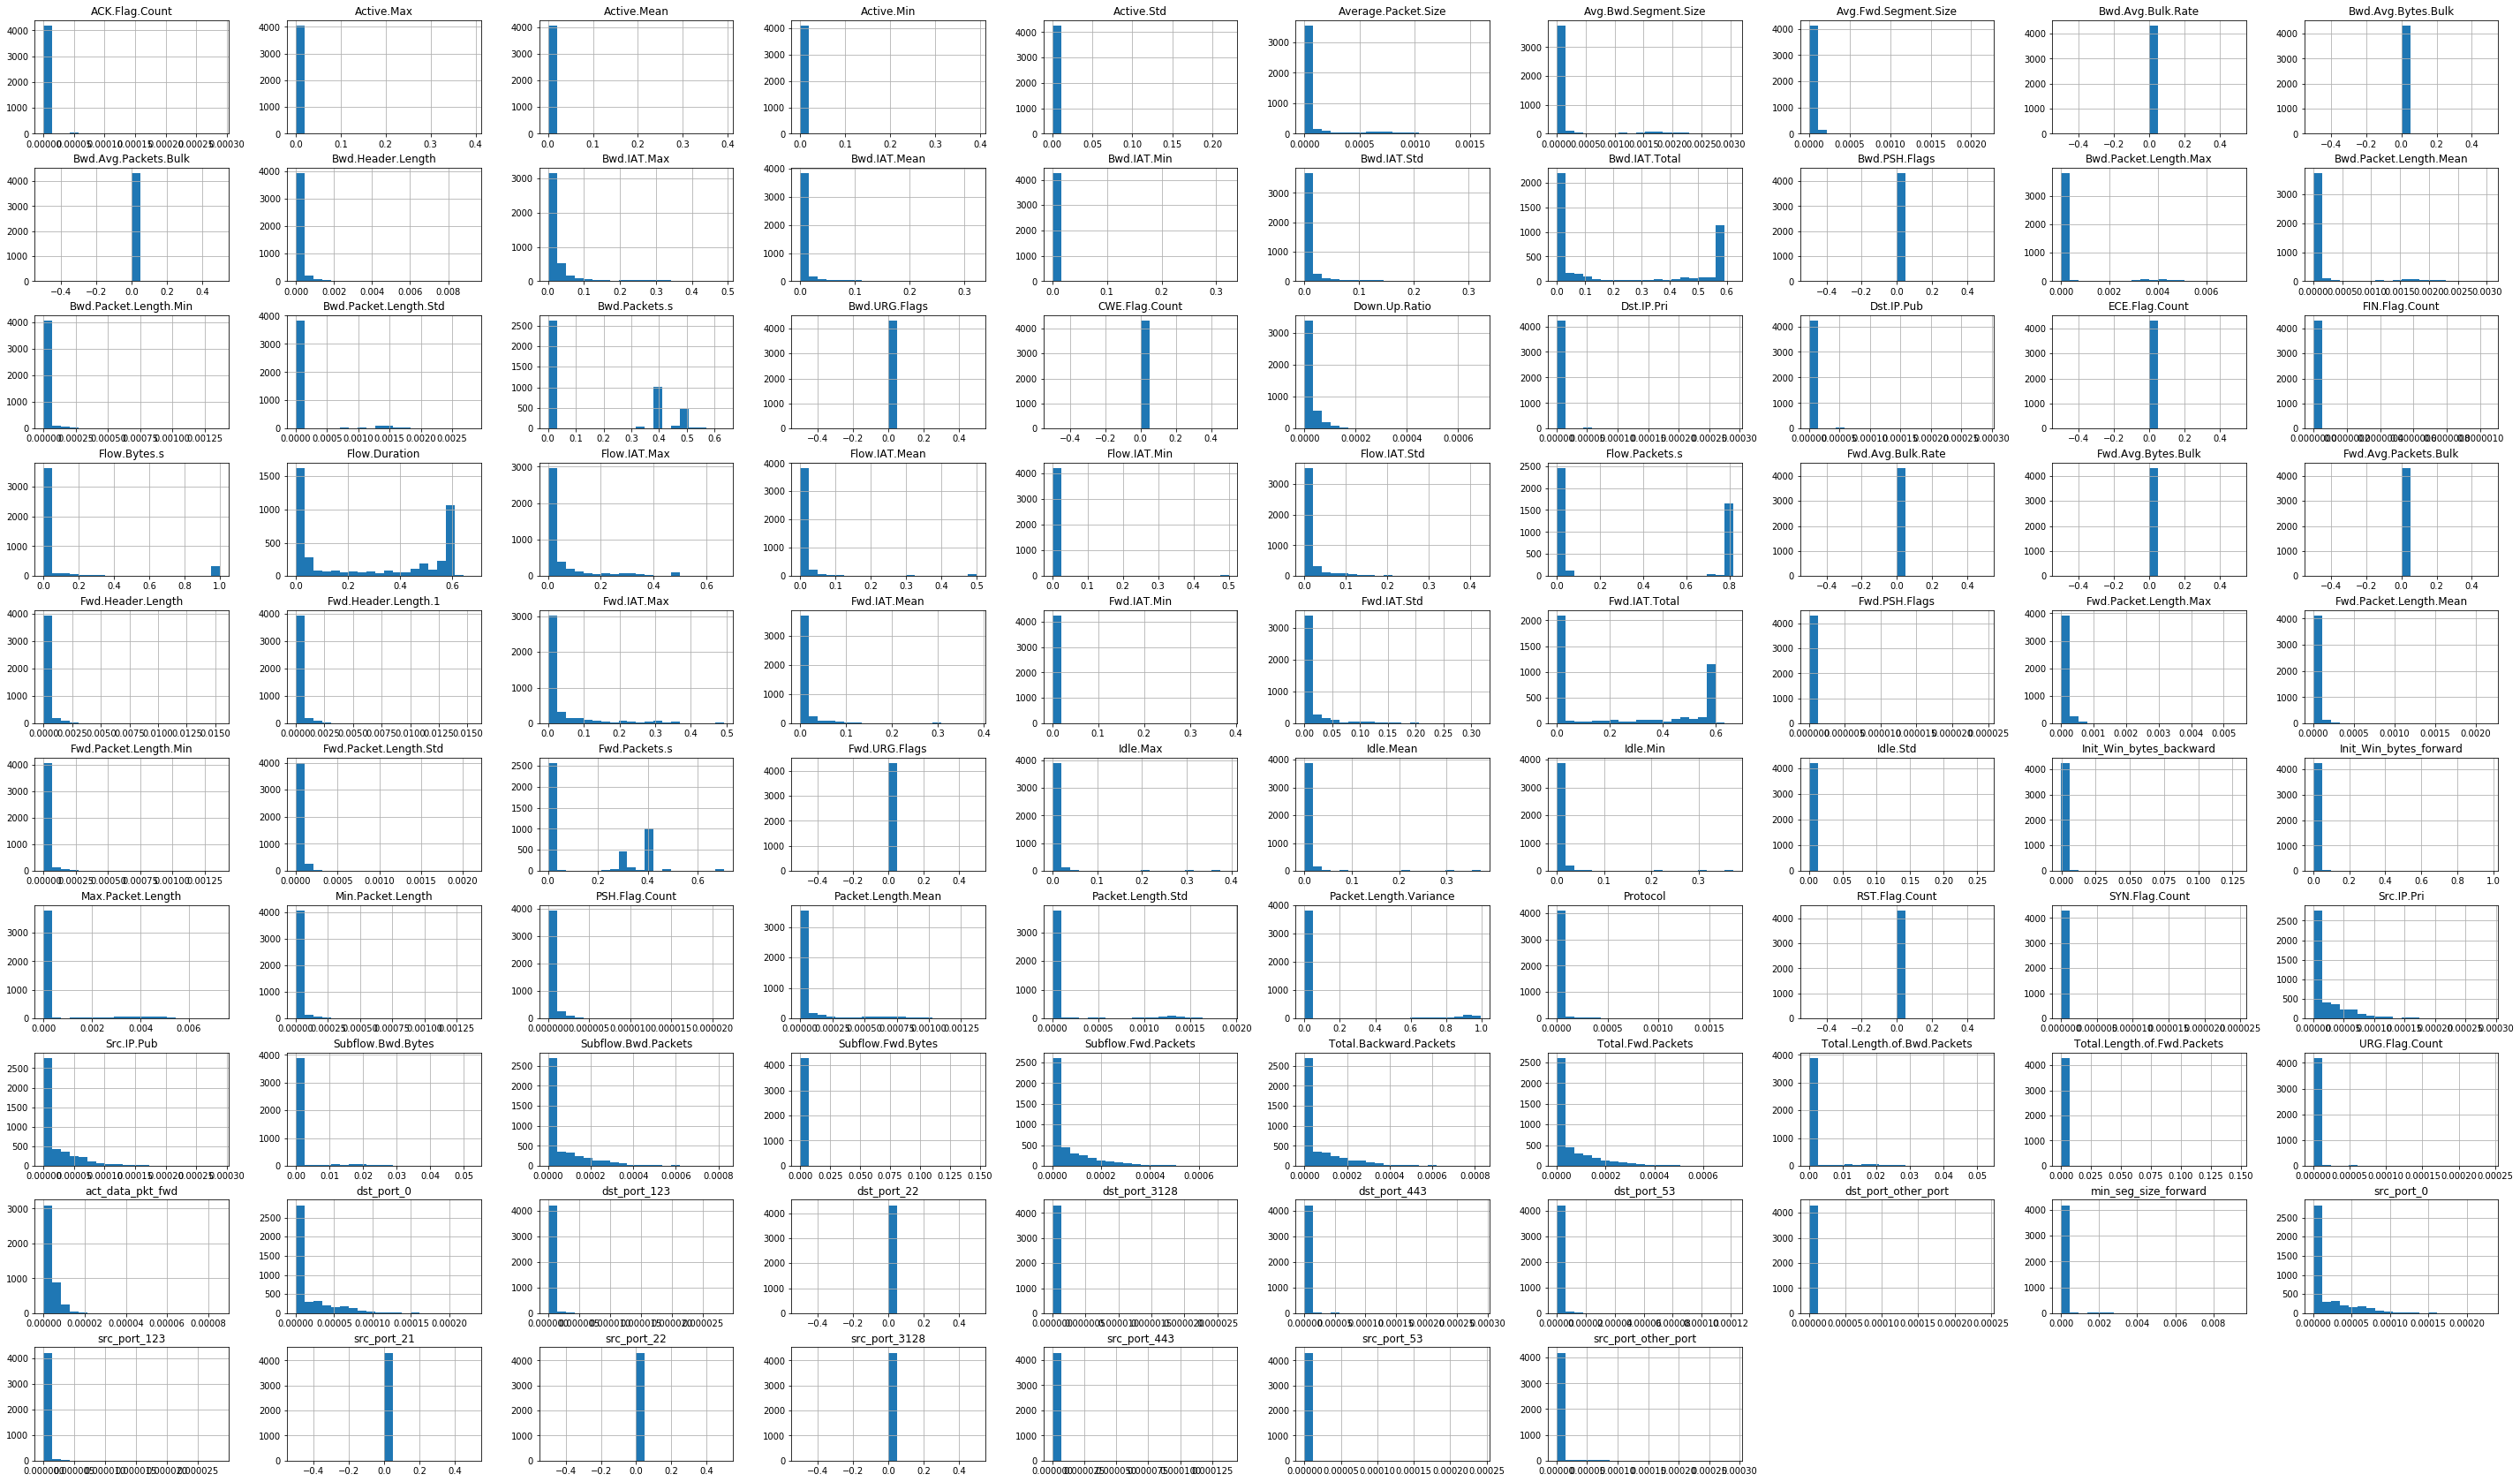

In [21]:
train_data_norm.hist(figsize=(50,30), bins=20)
plt.show()

<h1> Removal redundant data </h1>

In [22]:
pd.options.display.max_rows = 95
data_var = pd.DataFrame(train_data_norm.var())
display(data_var)
data_var.columns = ['vars']
keys = data_var.loc[data_var['vars'] == 0].to_dict()['vars'].keys()

,0
Protocol,7.792573e-09
Flow.Duration,6.418562e-02
Total.Fwd.Packets,1.013668e-08
Total.Backward.Packets,1.301627e-08
Total.Length.of.Fwd.Packets,9.112852e-06
...,...
dst_port_123,4.905358e-13
dst_port_53,2.536325e-11
dst_port_3128,2.767358e-13
dst_port_443,1.399811e-10


In [23]:
print(keys)
train_data.drop(keys, axis=1, inplace=True)

dict_keys(['Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'RST.Flag.Count', 'CWE.Flag.Count', 'ECE.Flag.Count', 'Fwd.Avg.Bytes.Bulk', 'Fwd.Avg.Packets.Bulk', 'Fwd.Avg.Bulk.Rate', 'Bwd.Avg.Bytes.Bulk', 'Bwd.Avg.Packets.Bulk', 'Bwd.Avg.Bulk.Rate', 'src_port_22', 'src_port_21', 'src_port_3128', 'dst_port_22'])


<h1> Clustering Model </h1>

visualize by PCA

In [24]:
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics

<h1> With label </h1>

,ProtocolName
1,3
2,3
3,3
4,3
5,3


/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Mutual_info: 1.0


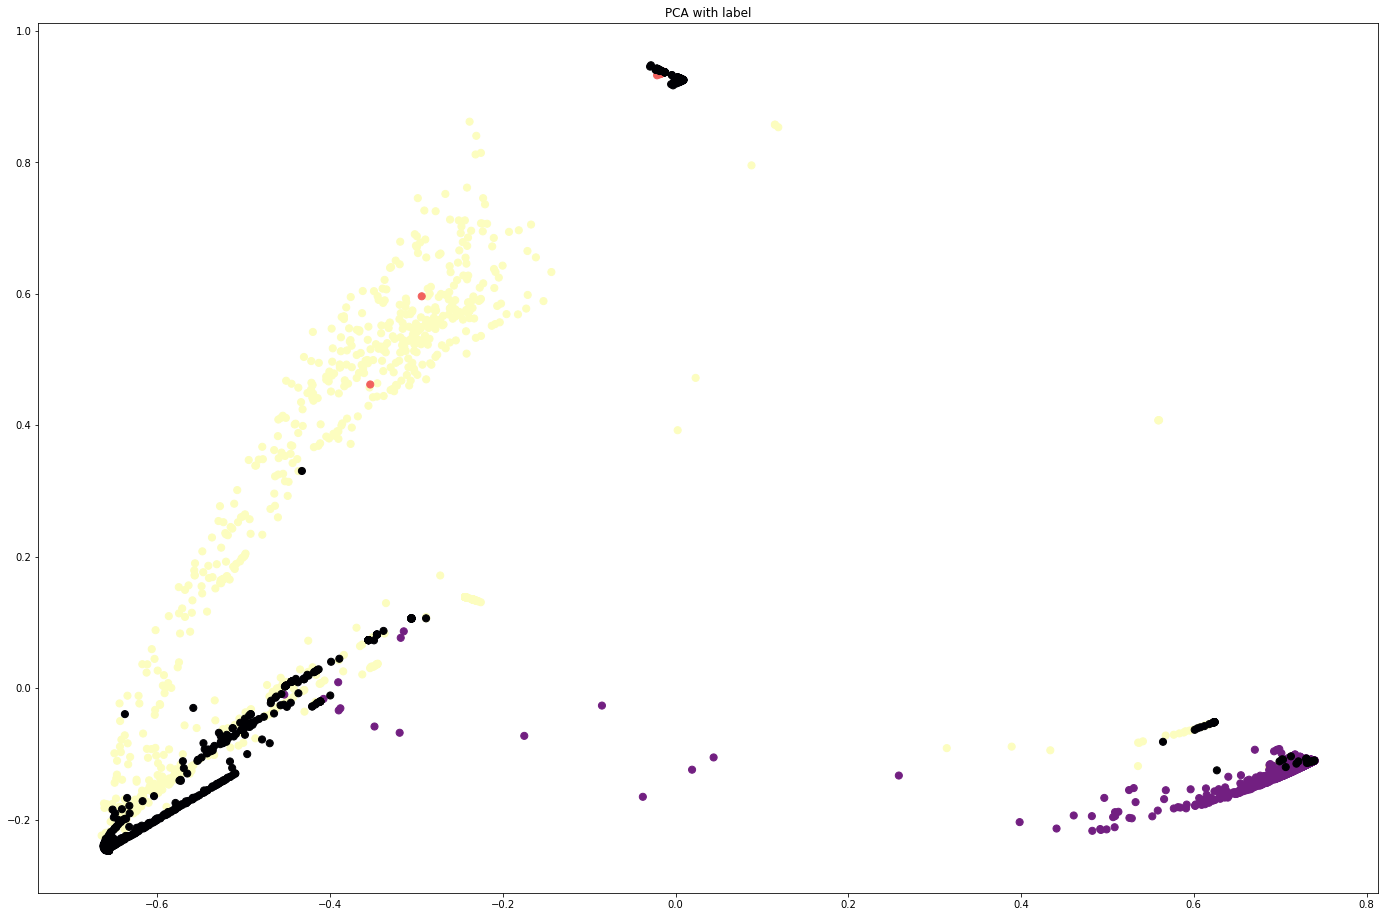

In [46]:
cm = ['black', 'red', 'green', 'purple']
pca = PCA(n_components=2)
res = pca.fit_transform(train_data_norm)

display(train_label.head())
plt.figure(figsize=(24,16))
plt.scatter(res[:,0], res[:,1], c=train_label.values[:, -1], s=50, cmap='magma')

plt.title('PCA with label')
print("Mutual_info:", metrics.adjusted_mutual_info_score(train_label.values[:, -1], train_label.values[:, -1]))

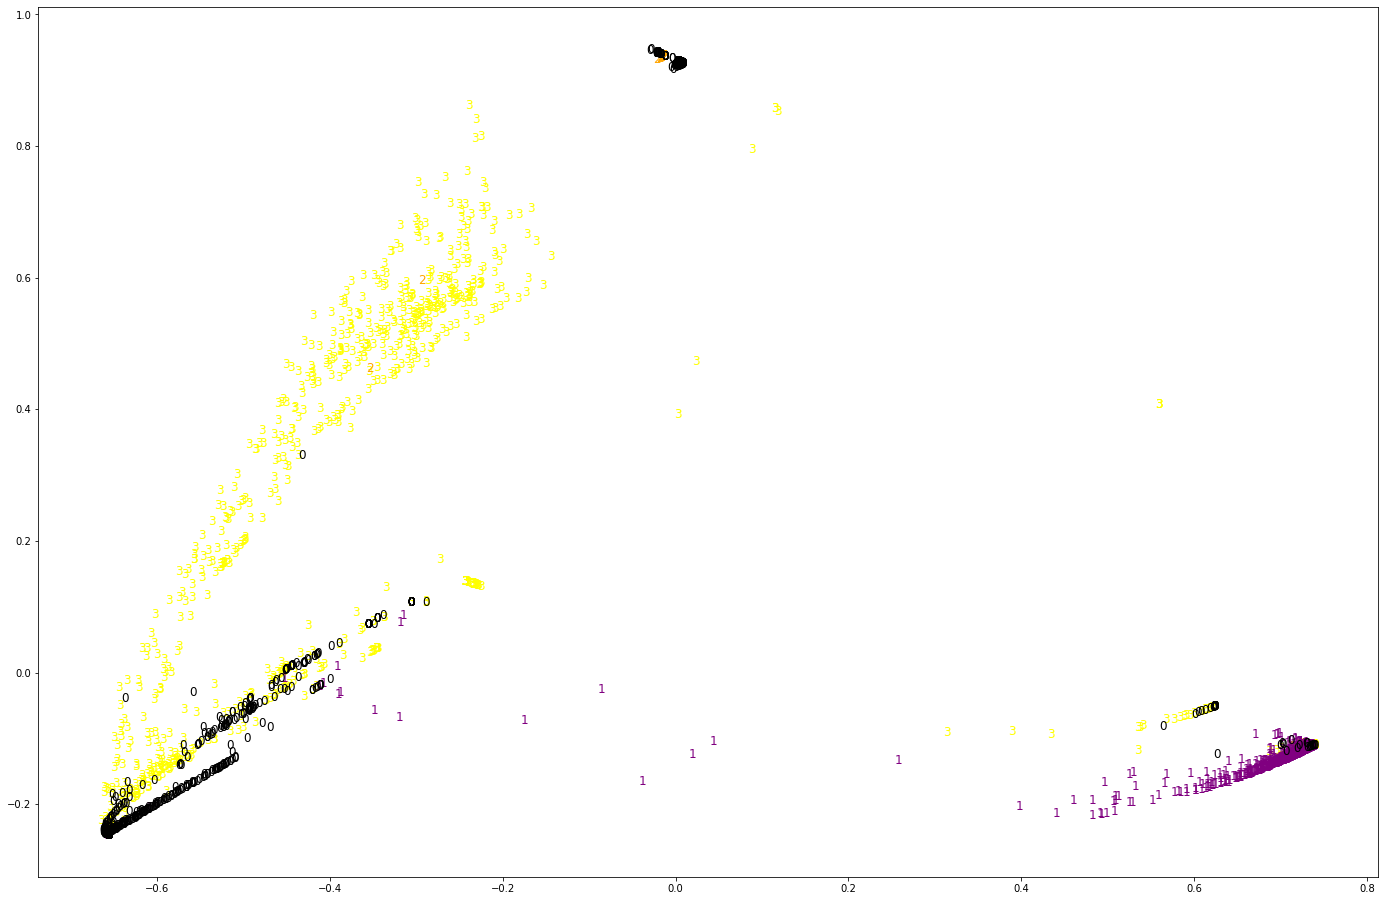

In [26]:
plt.figure(figsize=(24,16))
label_list = train_label.values[:, -1]

for i, xy in enumerate(res):
    plt.text(xy[0], xy[1], str(label_list[i]), fontsize=12, 
             c=cmap[label_list[i]], ha="center", va="center")

plt.scatter(res[:,0], res[:,1], alpha=0) 

Mutual_info: 0.6538732497503071


/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Text(0.5, 1.0, 'Kmeans')

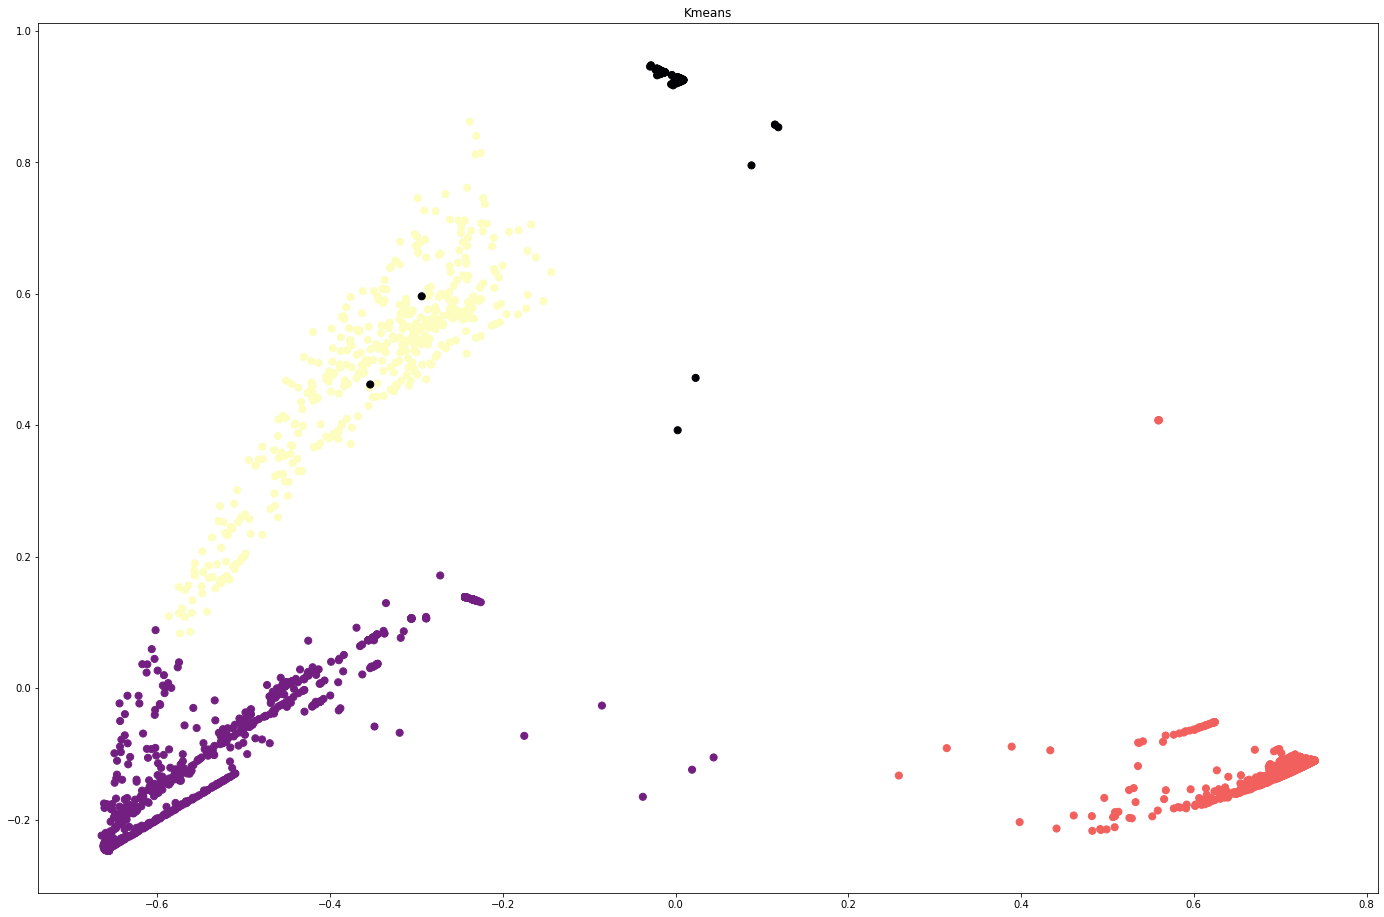

In [36]:
kmeans = KMeans(n_clusters=4, random_state=180, max_iter=400, n_init=4, init='k-means++', algorithm='elkan').fit(train_data_norm)
print("Mutual_info:", metrics.adjusted_mutual_info_score(kmeans.labels_, train_label.values[:, -1]))

plt.figure(figsize=(24,16))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='magma')
plt.title('Kmeans')

Text(0.5, 1.0, 'Kmeans')

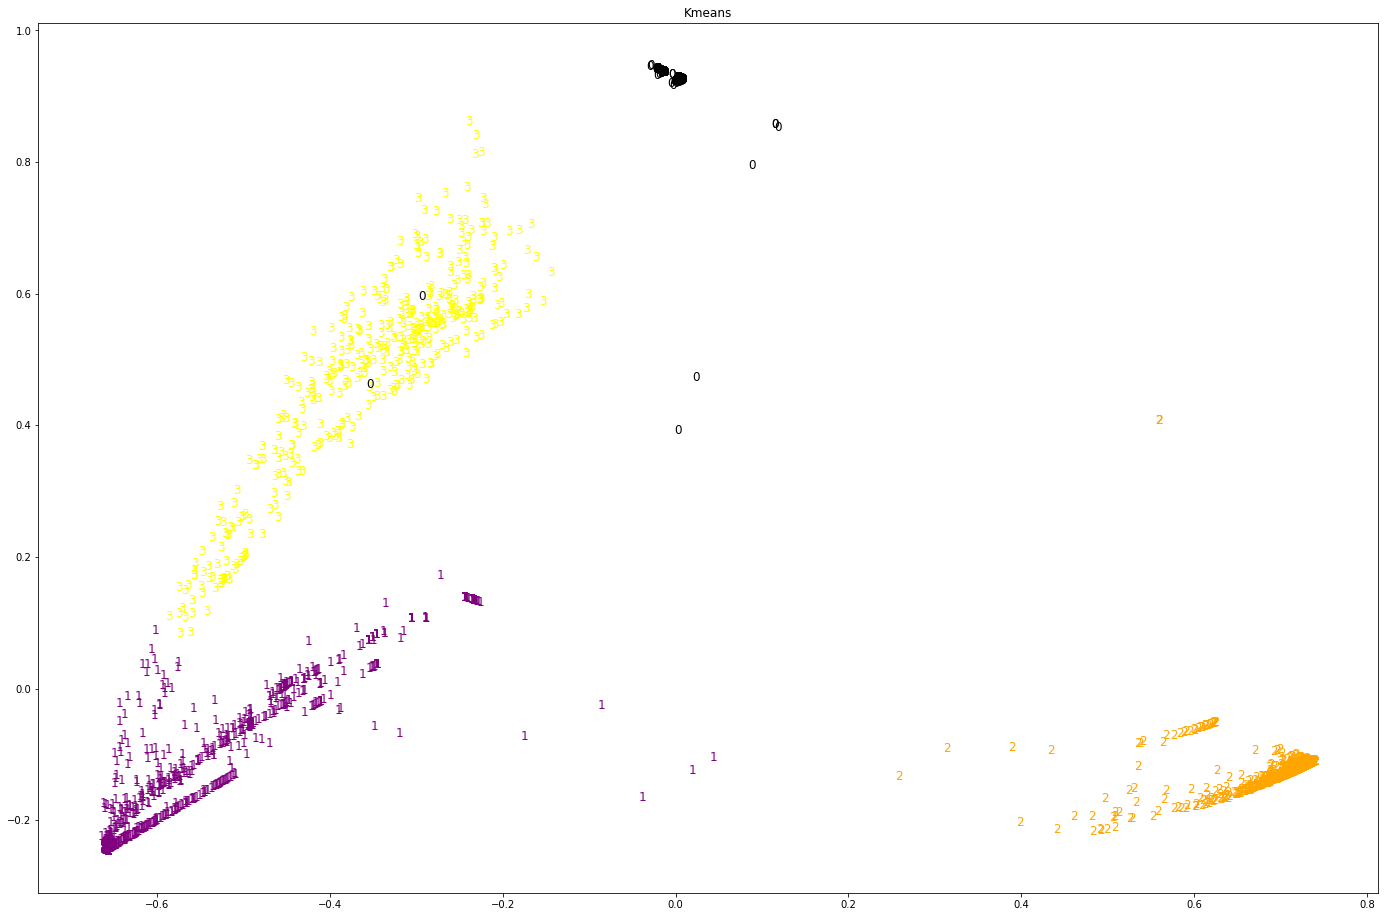

In [39]:
cmap = ['black', 'purple', 'orange', 'yellow']

plt.figure(figsize=(24,16))
pred_label = kmeans.labels_

for i, xy in enumerate(res):
    plt.text(xy[0], xy[1], str(pred_label[i]), fontsize=12, 
             c=cmap[pred_label[i]], ha="center", va="center")

plt.scatter(res[:,0], res[:,1], alpha=0) 
plt.title('Kmeans')

/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Mutual_info: 0.6311374732858199


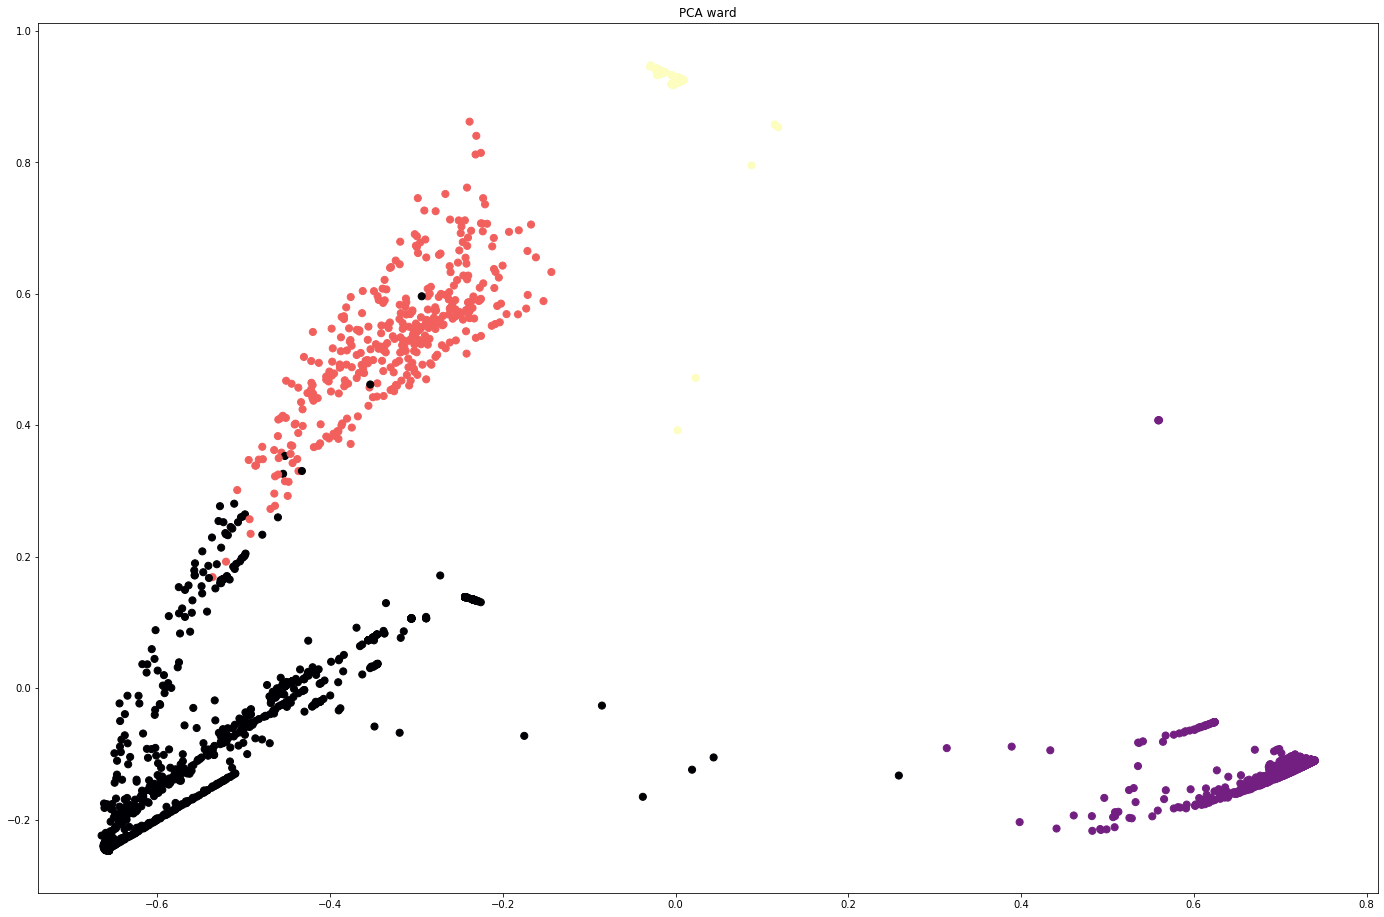

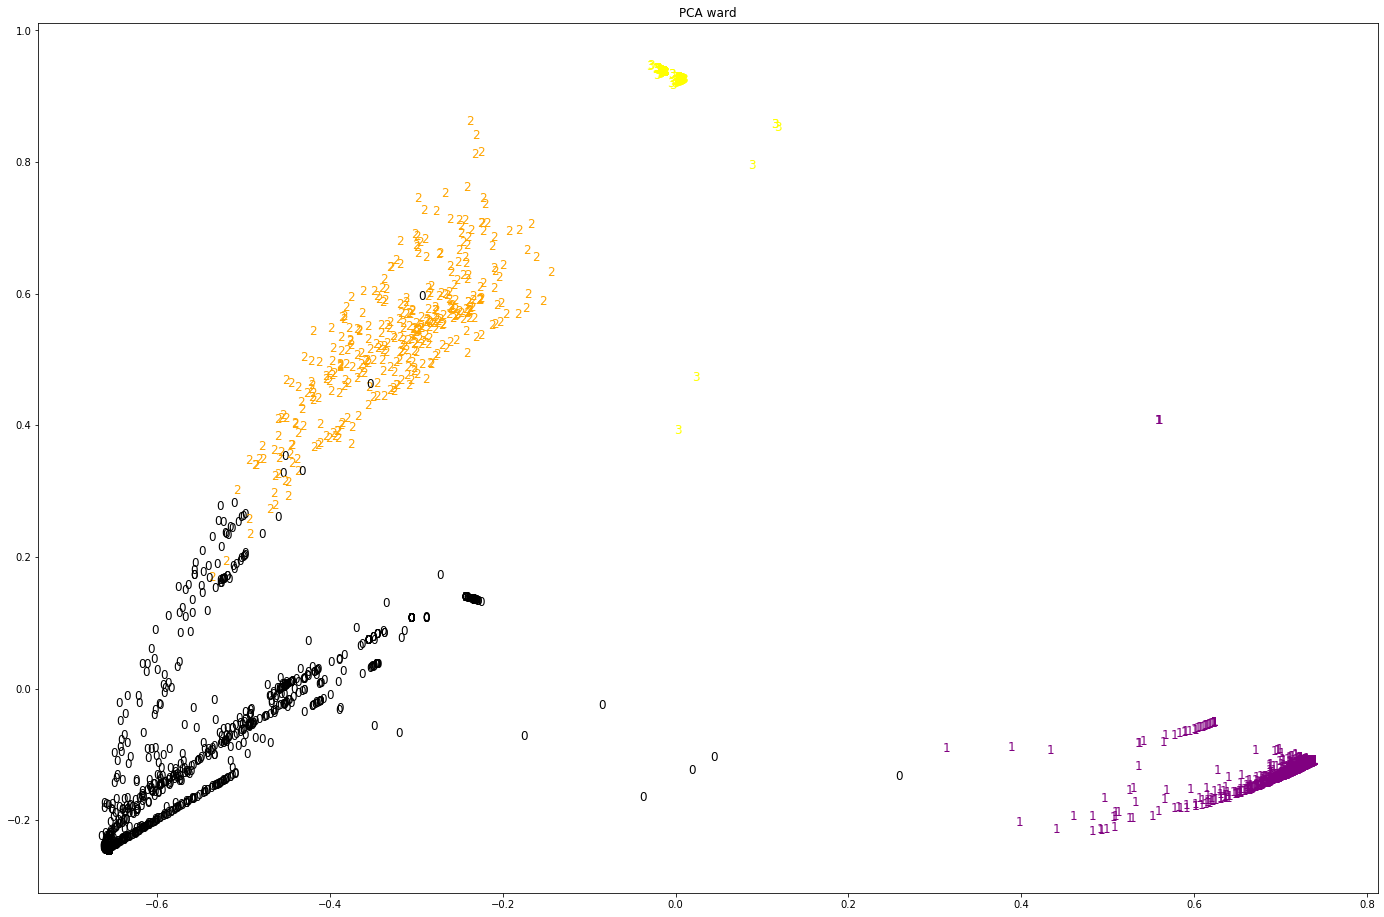

/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Mutual_info: 0.540523513145126


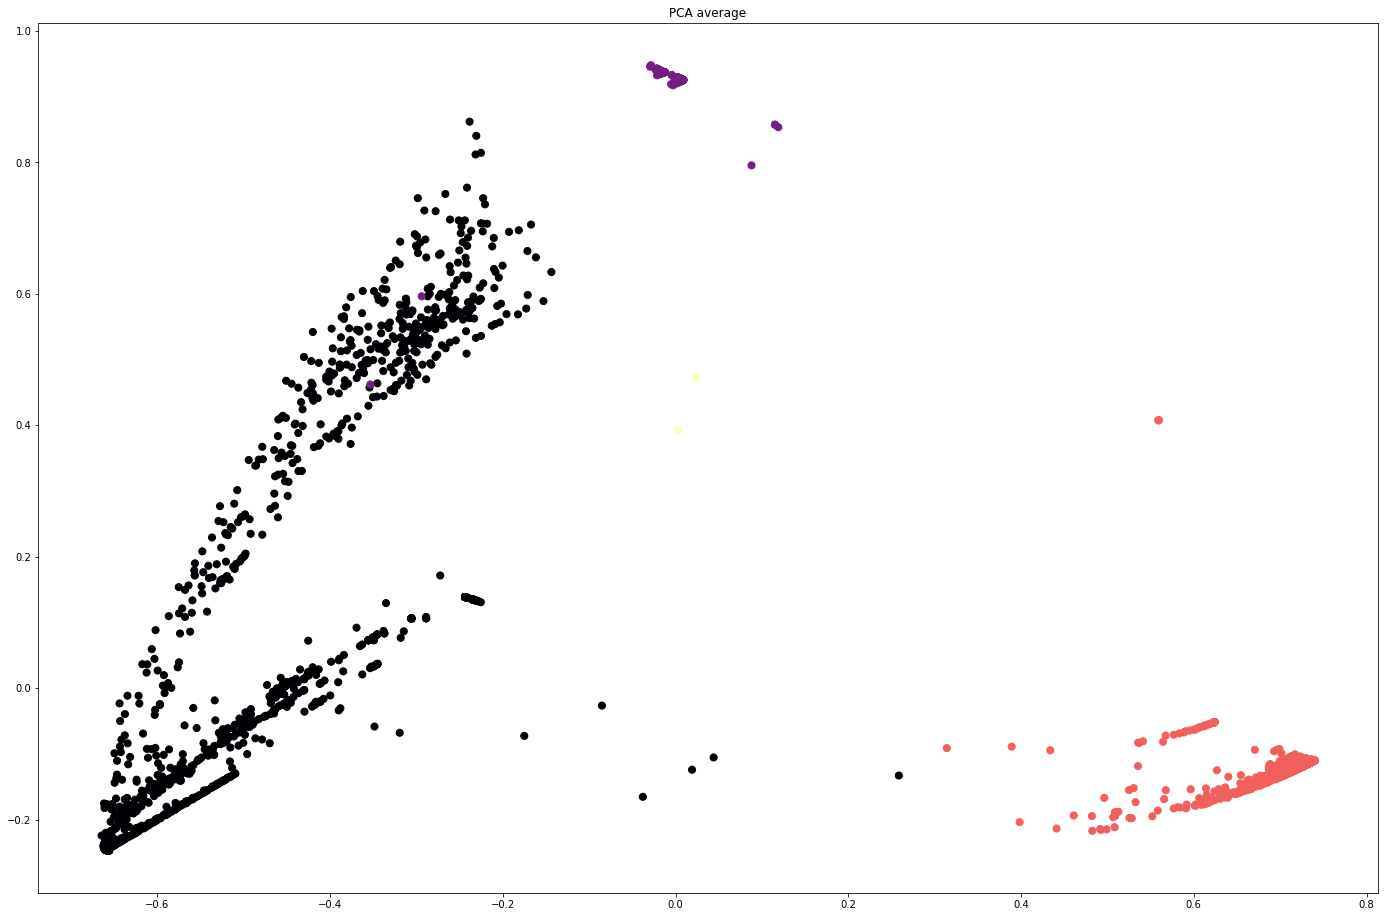

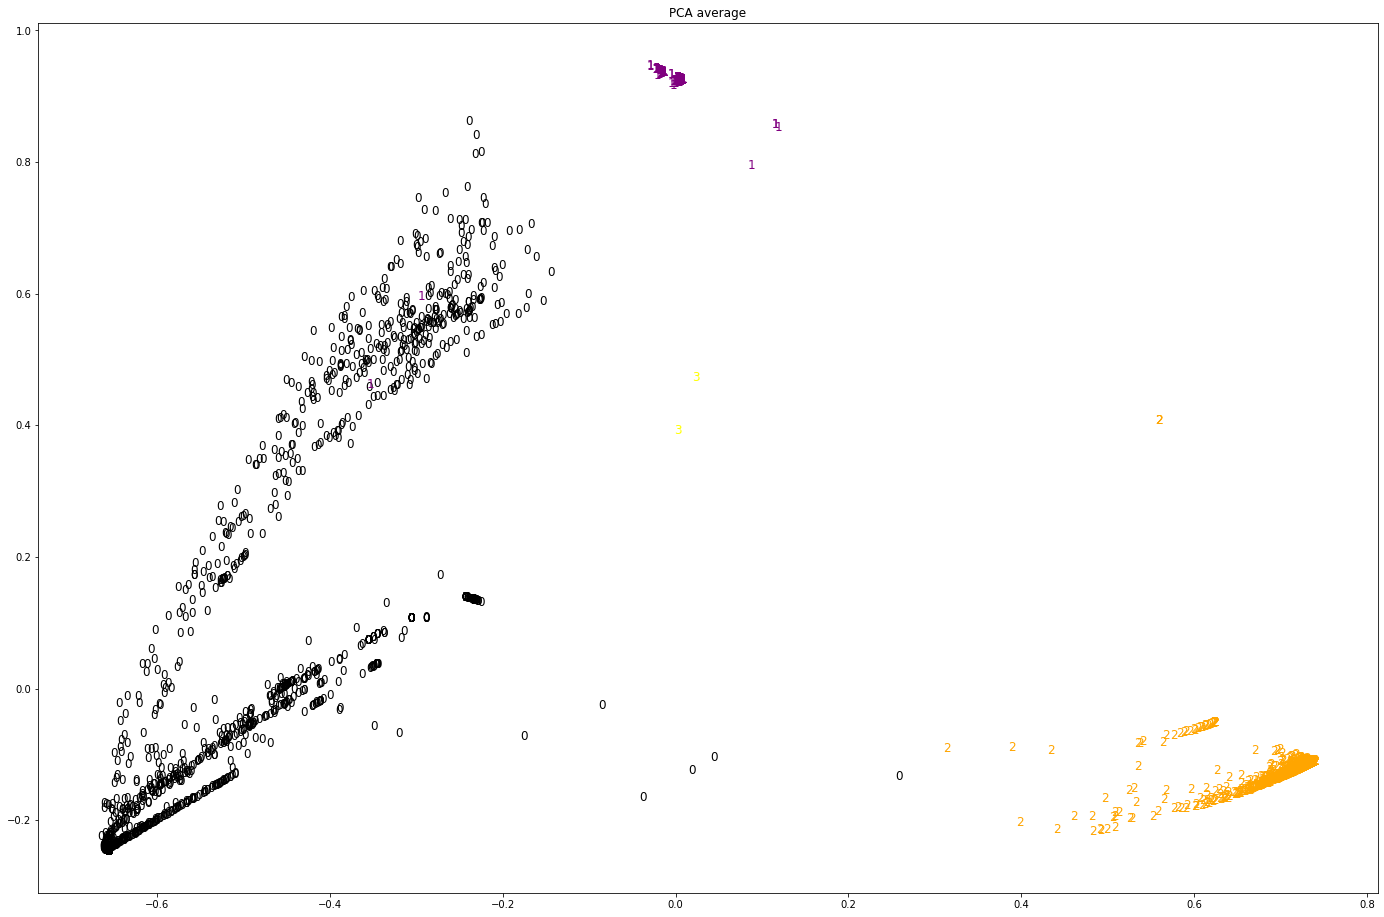

/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Mutual_info: 0.6553175722145245


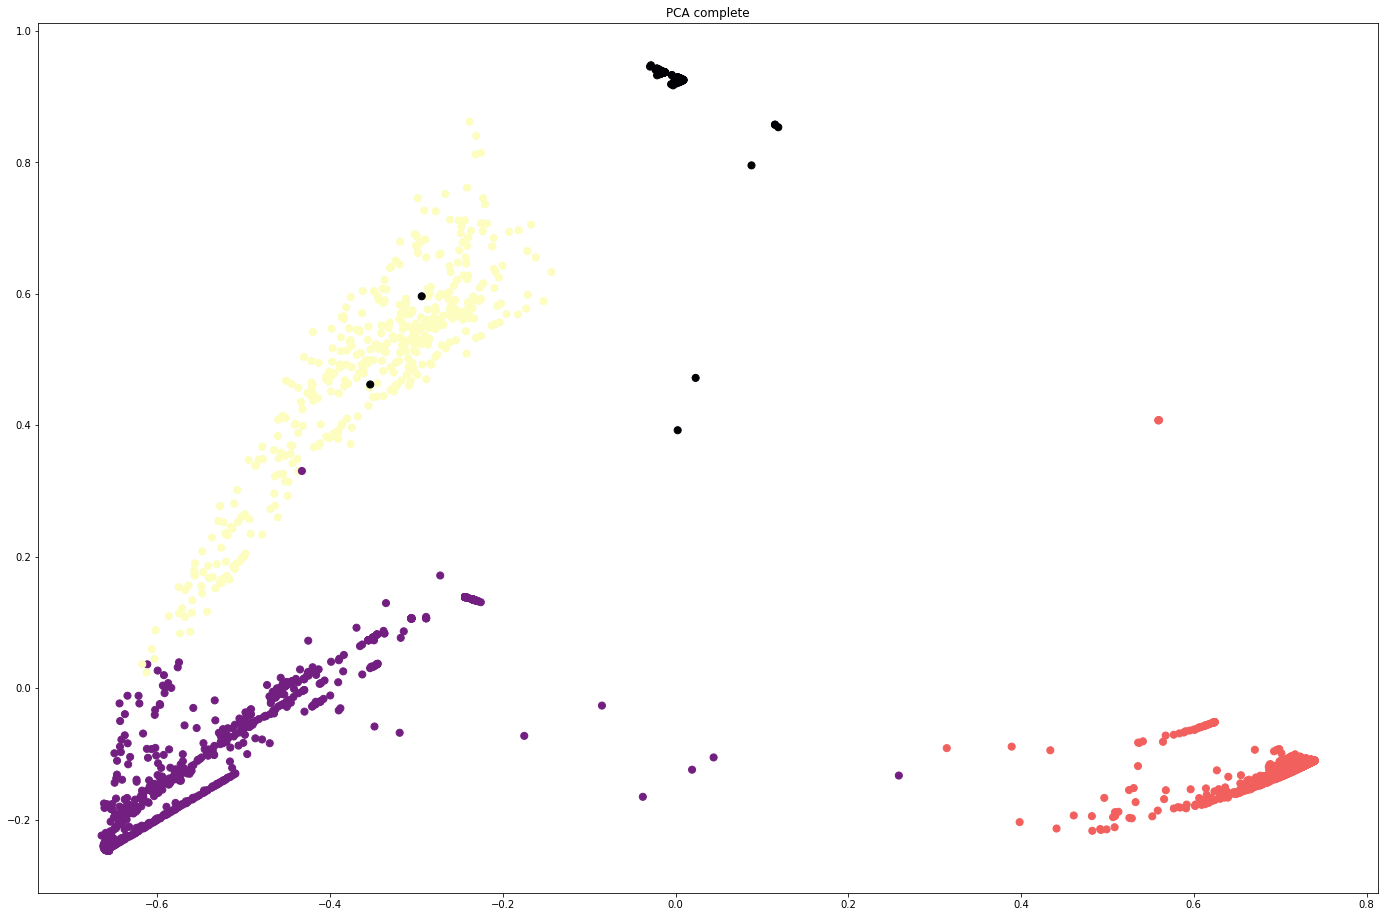

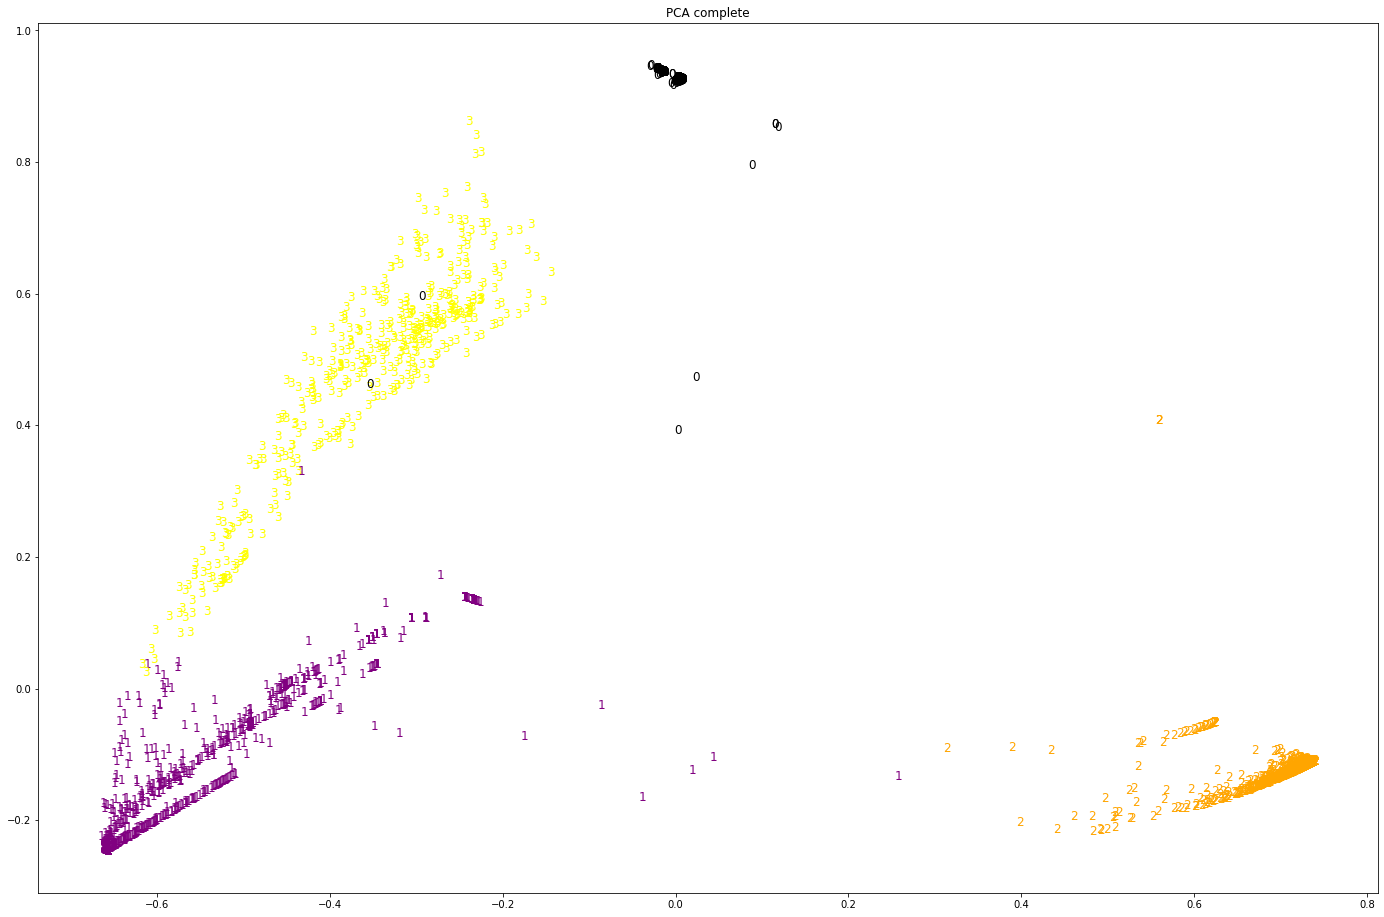

/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Mutual_info: 0.12367314047095906


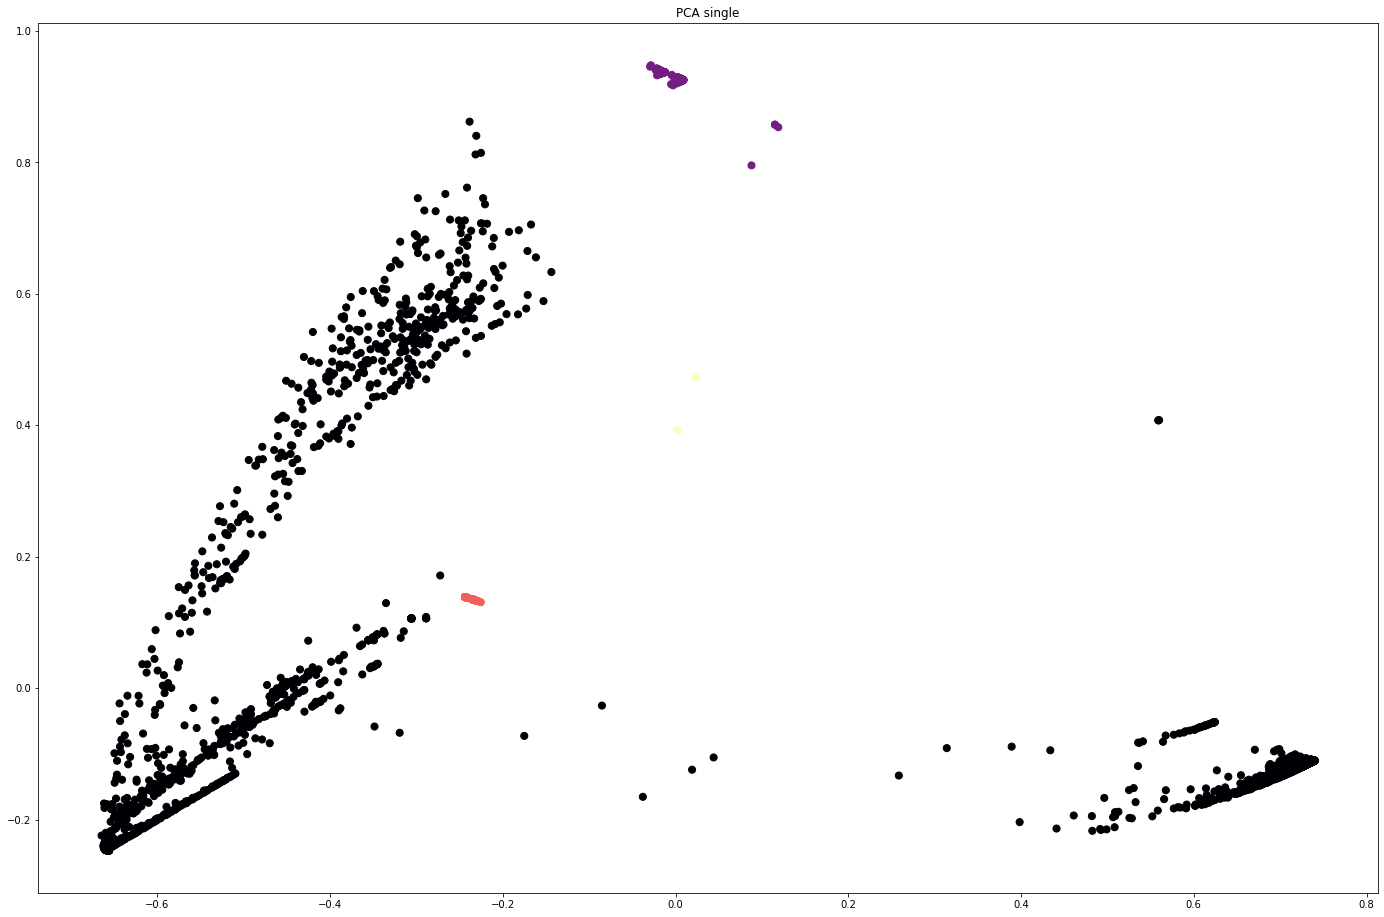

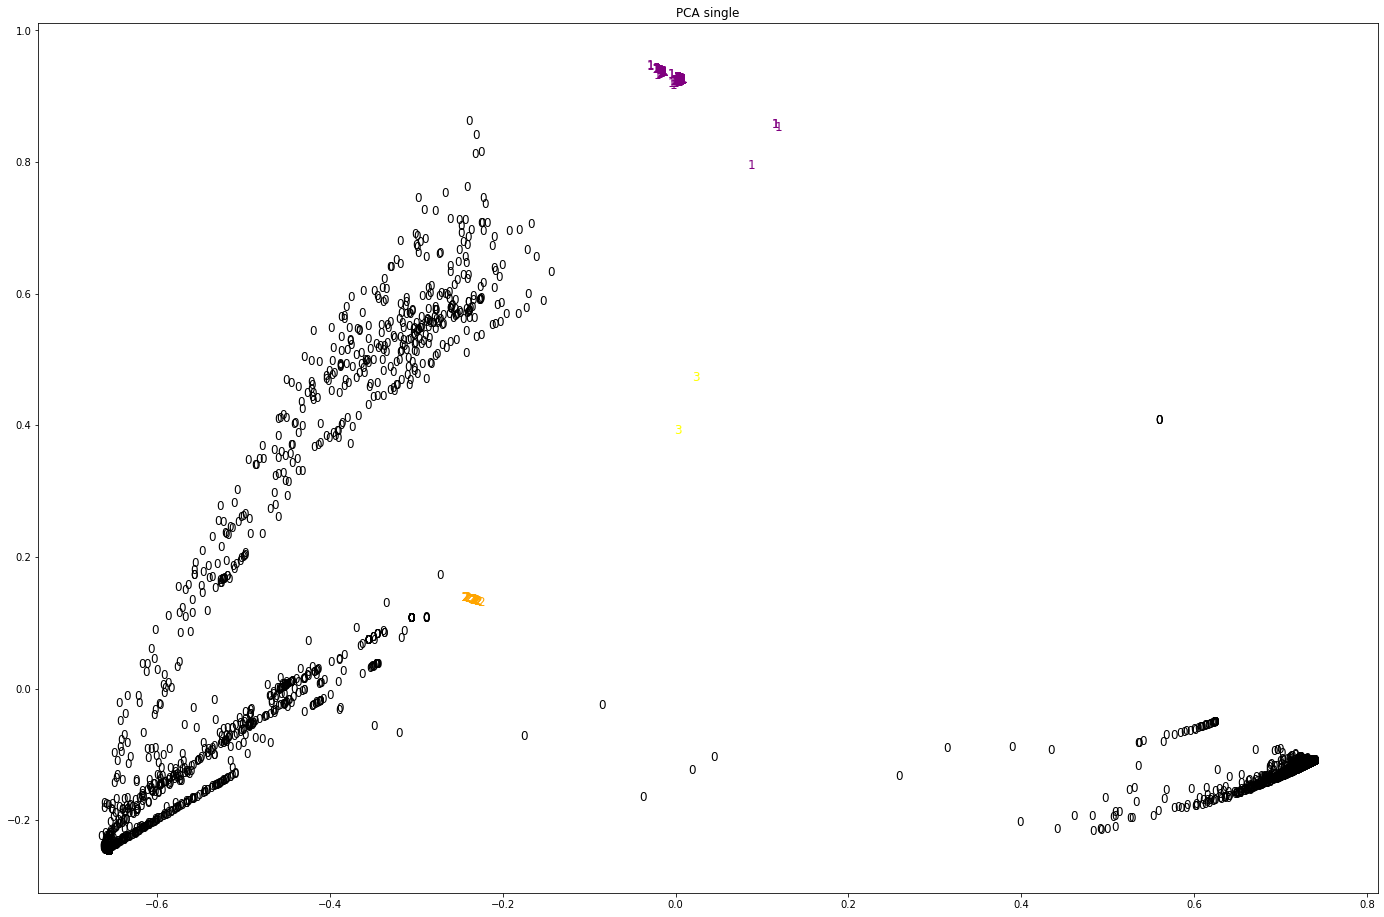

In [43]:
cmap = ['black', 'purple', 'orange', 'yellow']

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=4).fit(train_data_norm)
    print("Mutual_info:", metrics.adjusted_mutual_info_score(clustering.labels_, train_label.values[:, -1]))
    plt.figure(figsize=(24,16))
    plt.scatter(res[:,0], res[:,1], c=clustering.labels_, s=50, cmap='magma')
    plt.title('PCA ' + linkage)
    plt.show()
    
    
    plt.figure(figsize=(24,16))
    pred_label = clustering.labels_
    for i, xy in enumerate(res):
        plt.text(xy[0], xy[1], str(pred_label[i]), fontsize=12, 
                 c=cmap[pred_label[i]], ha="center", va="center")

    plt.scatter(res[:,0], res[:,1], alpha=0) 
    plt.title('PCA ' + linkage)
    plt.show()

In [41]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn import metrics

Estimated number of clusters: 3
Estimated number of noise points: 6
Mutual_info: 0.12563782688642364


/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Text(0.5, 1.0, 'DBScan')

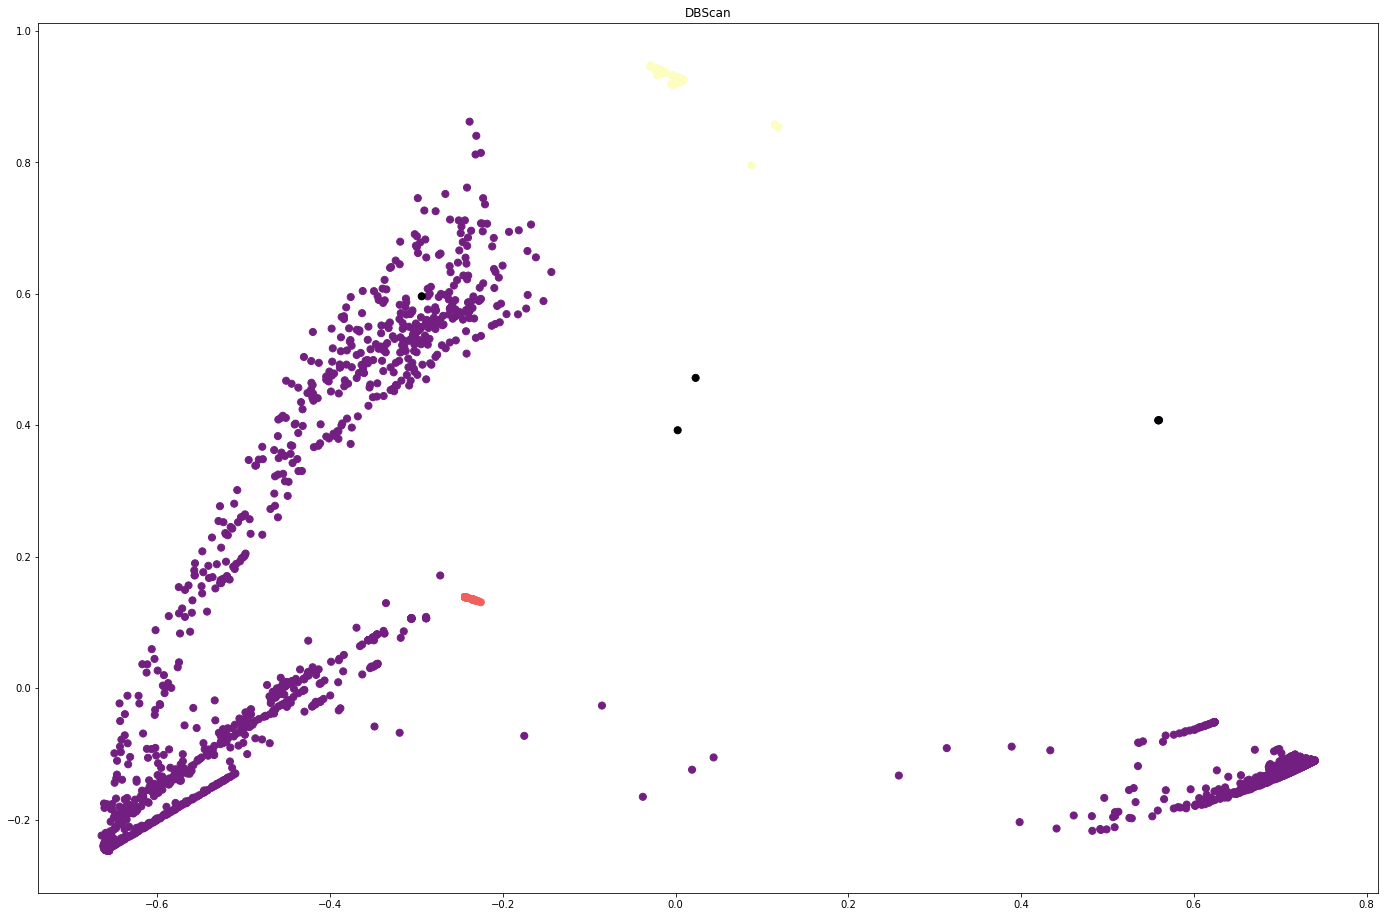

In [47]:
db = DBSCAN(eps=0.6, min_samples=10).fit(train_data_norm)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Mutual_info:", metrics.adjusted_mutual_info_score(db.labels_, train_label.values[:, -1]))
plt.figure(figsize=(24,16))
plt.scatter(res[:,0], res[:,1], c=labels, s=50, cmap='magma')
plt.title('DBScan')

<h1> Student </h1>

In [61]:
train_file = "res/raw_data.csv"
header_file = "res/header.csv"

names = None
with open(header_file, 'r') as f:
    for l in f:
        names = l.strip('\n').split(',')
    names = names
    
train_data = pd.read_csv(train_file, names=names, low_memory=False)

In [62]:
train_data = train_data = train_data.iloc[1:]
train_data.head()

,ID,Flow.ID,Source.IP,Source.Port,Destination.IP,...,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label
1,1651,172.217.29.66-10.200.7.196-443-39485-6,10.200.7.196,39485,172.217.29.66,...,0,0,0,0,BENIGN
2,6460,179.1.4.244-10.200.7.196-443-43024-6,10.200.7.196,43024,179.1.4.244,...,0,0,0,0,BENIGN
3,6578,179.1.4.244-10.200.7.196-443-43031-6,10.200.7.196,43031,179.1.4.244,...,0,0,0,0,BENIGN
4,7219,179.1.4.244-10.200.7.196-443-43064-6,10.200.7.196,43064,179.1.4.244,...,0,0,0,0,BENIGN
5,7683,179.1.4.244-10.200.7.196-443-43076-6,10.200.7.196,43076,179.1.4.244,...,0,0,0,0,BENIGN


In [63]:
train_data.shape

(4317, 86)

In [64]:
# remove uesless attr.
# ID, flow id, timestamp, Label 
train_data.drop(['ID', 'Flow.ID', 'Timestamp', 'Label'], axis=1, inplace=True)

In [65]:
# private IP & public IP
import ipaddress 

srcIPPub = []
srcIPPri = []
for ip in train_data['Source.IP']:
    if ipaddress.ip_address(ip).is_private:
        srcIPPub.append(0)
        srcIPPri.append(1)
    else:
        srcIPPub.append(1)
        srcIPPri.append(0)

dstIPPub = []
dstIPPri = []
for ip in train_data['Destination.IP']:
    if ipaddress.ip_address(ip).is_private:
        dstIPPub.append(0)
        dstIPPri.append(1)
    else:
        dstIPPub.append(1)
        dstIPPri.append(0)

train_data['Dst.IP.Pub'] = dstIPPub
train_data['Src.IP.Pub'] = srcIPPri
train_data['Dst.IP.Pri'] = dstIPPub
train_data['Src.IP.Pri'] = srcIPPri

In [66]:
one_hot_src_map = {'0': [], '22': [], '21': [], '123': [], '53': [], '3128': [], '443': [], 'other_port':[]}
one_hot_dst_map = {'0': [], '22': [], '22': [], '123': [], '53': [], '3128': [], '443': [], 'other_port':[]}

l = train_data.shape[0]

for k in one_hot_src_map:
    one_hot_src_map[k] = [0]*l
    
for i, port in enumerate(train_data['Source.Port']):
    if str(port) in one_hot_src_map:
        one_hot_src_map[str(port)][i] = 1
    else:
        one_hot_src_map['other_port'][i] = 1
        
for k in one_hot_dst_map:
    one_hot_dst_map[k] = [0]*l
    
for i, port in enumerate(train_data['Destination.Port']):
    if str(port) in one_hot_dst_map:
        one_hot_dst_map[str(port)][i] = 1
    else:
        one_hot_dst_map['other_port'][i] = 1

In [67]:
for k in one_hot_src_map:
    train_data['src_port_' + k] = one_hot_src_map[k]

for k in one_hot_dst_map:
    train_data['dst_port_' + k] = one_hot_dst_map[k]

In [68]:
train_data.drop(['Source.Port', 'Source.IP', 'Destination.Port', 'Destination.IP'], axis=1, inplace=True)

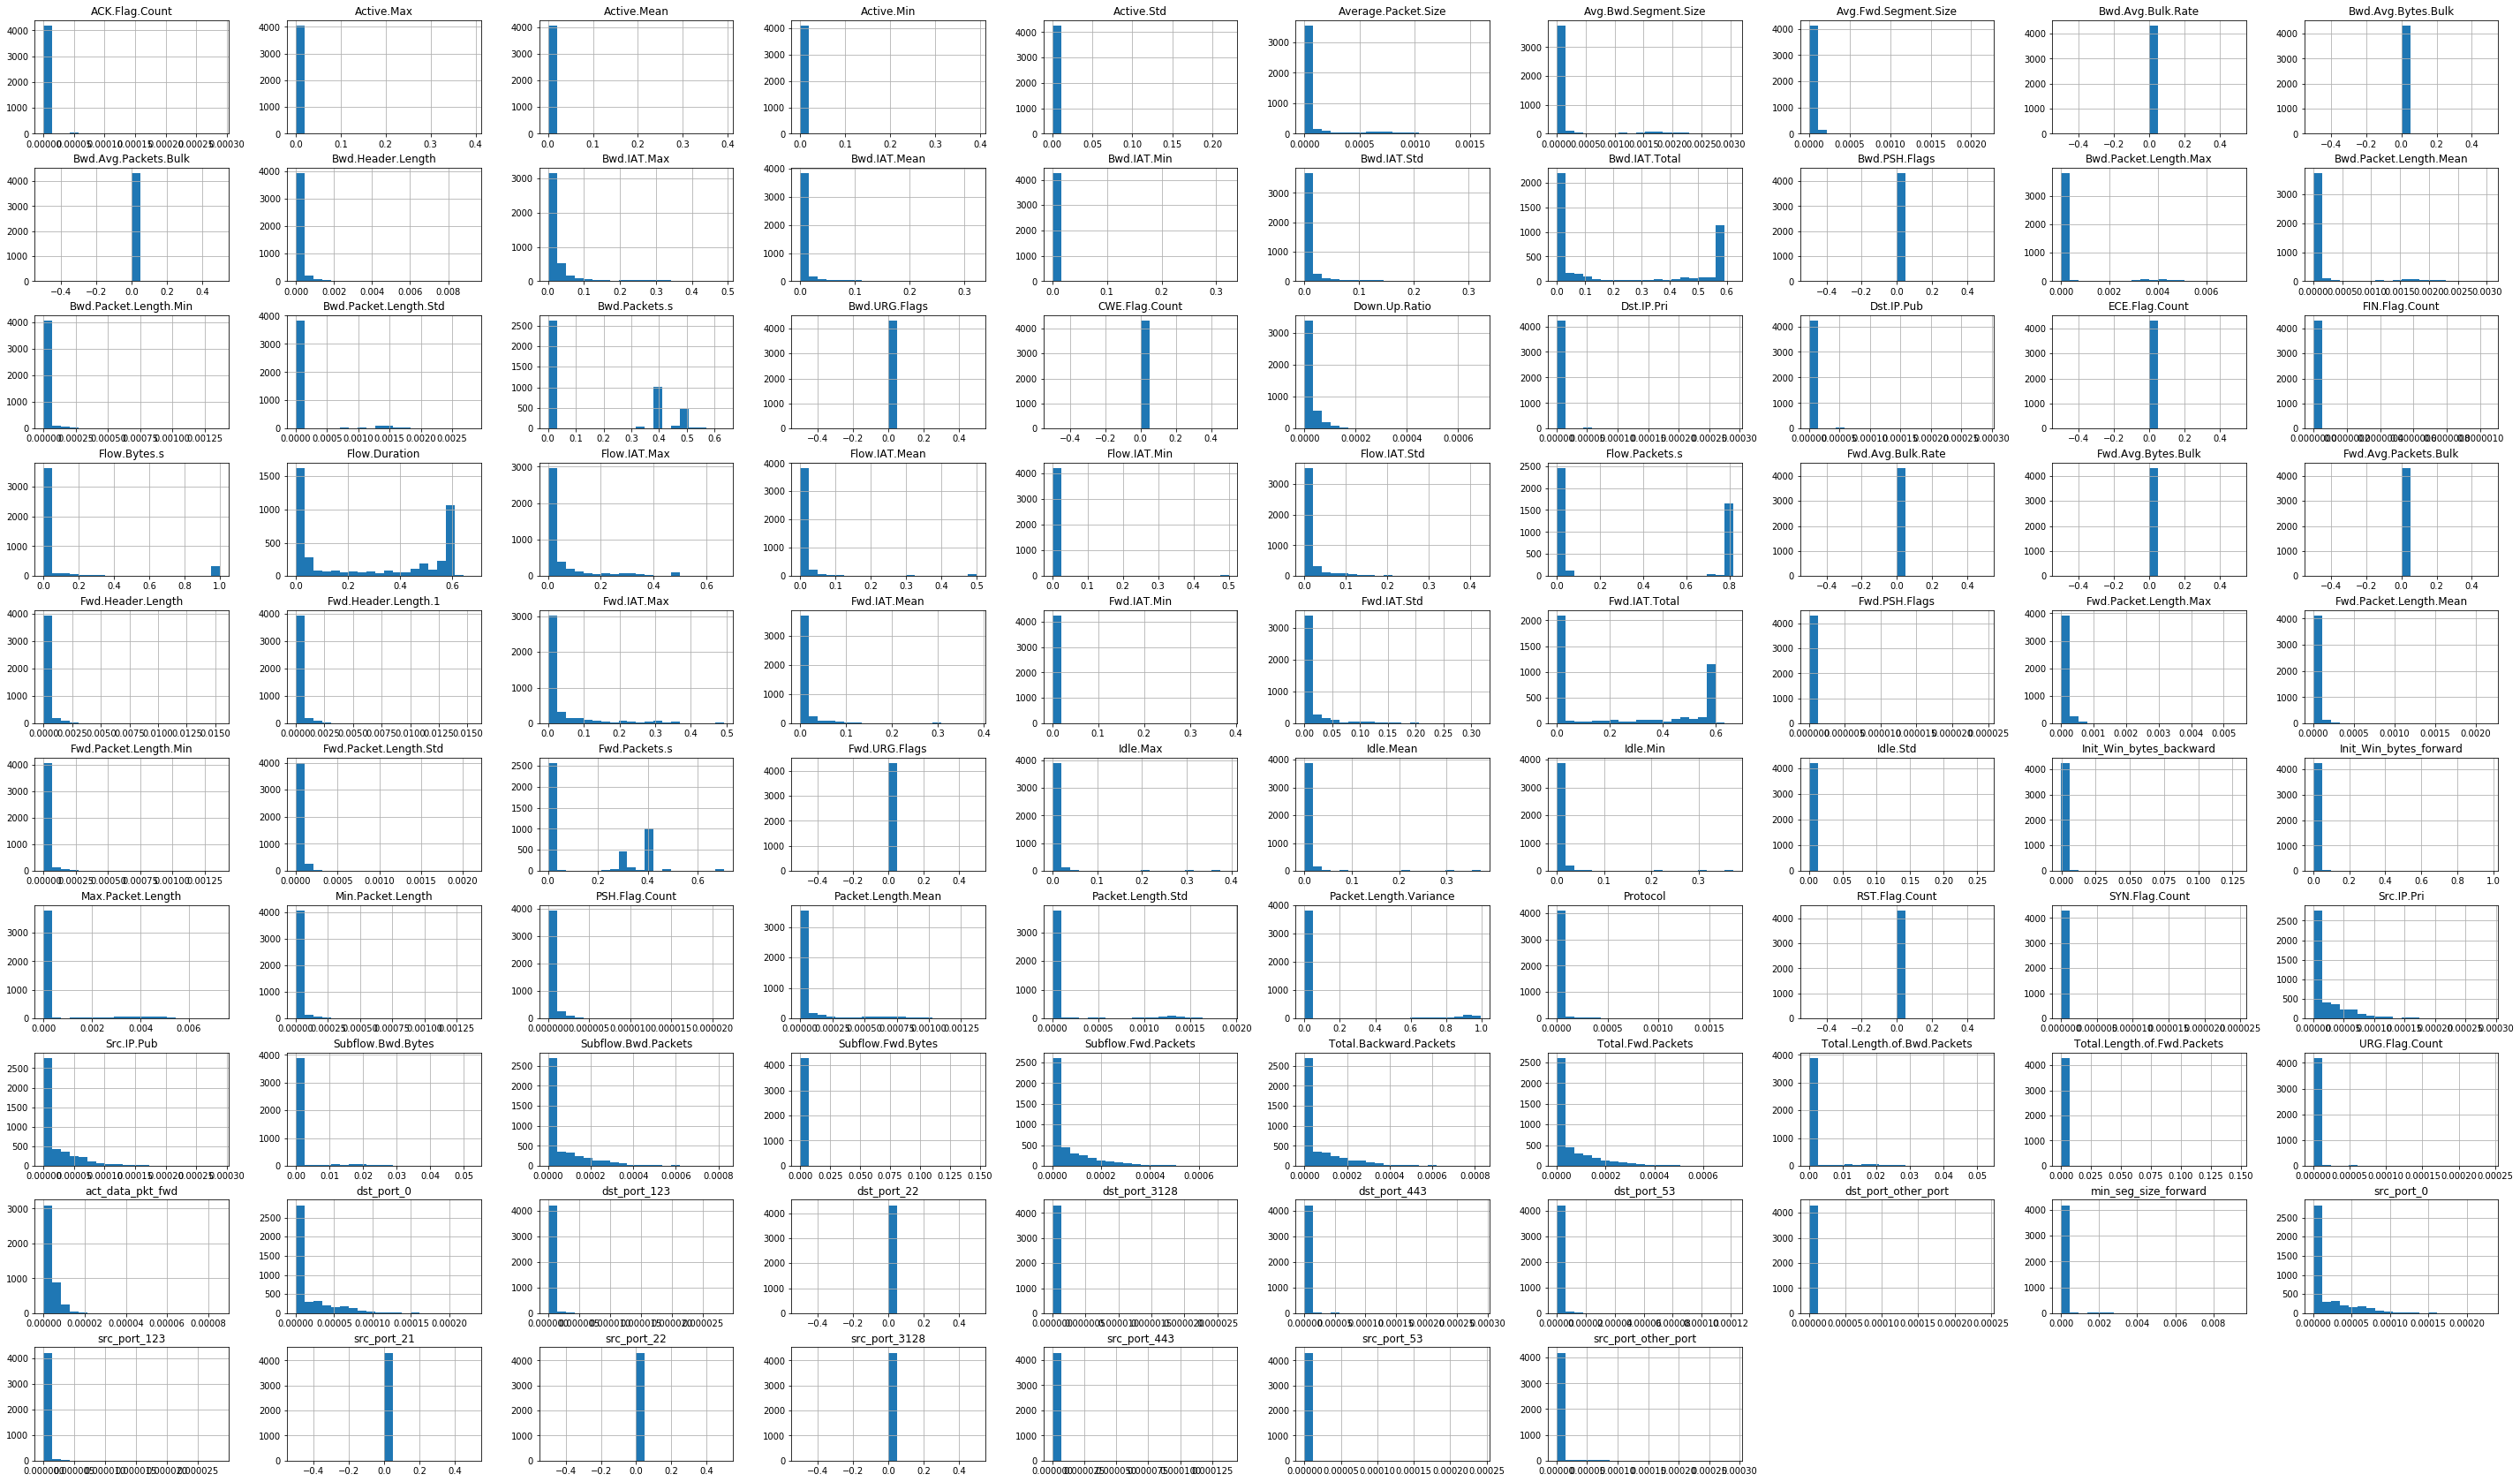

In [69]:
from sklearn.preprocessing import Normalizer

norm = Normalizer(norm='l2')
normalized_data = norm.fit_transform(train_data)

train_data_norm = pd.DataFrame(data=normalized_data, columns=train_data.columns)

train_data_norm.hist(figsize=(50,30), bins=20)
plt.show()

In [70]:
pd.options.display.max_rows = 95
data_var = pd.DataFrame(train_data_norm.var())
display(data_var)
data_var.columns = ['vars']
keys = data_var.loc[data_var['vars'] == 0].to_dict()['vars'].keys()

print(keys)
train_data.drop(keys, axis=1, inplace=True)

,0
Protocol,7.792573e-09
Flow.Duration,6.418562e-02
Total.Fwd.Packets,1.013668e-08
Total.Backward.Packets,1.301627e-08
Total.Length.of.Fwd.Packets,9.112852e-06
...,...
dst_port_123,4.905358e-13
dst_port_53,2.536325e-11
dst_port_3128,2.767358e-13
dst_port_443,1.399811e-10


dict_keys(['Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'RST.Flag.Count', 'CWE.Flag.Count', 'ECE.Flag.Count', 'Fwd.Avg.Bytes.Bulk', 'Fwd.Avg.Packets.Bulk', 'Fwd.Avg.Bulk.Rate', 'Bwd.Avg.Bytes.Bulk', 'Bwd.Avg.Packets.Bulk', 'Bwd.Avg.Bulk.Rate', 'src_port_22', 'src_port_21', 'src_port_3128', 'dst_port_22'])


In [71]:
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics

In [74]:
train_file = "res/cluster.csv"
names = ['ID', 'ProtocolName']

train_label = pd.read_csv(train_file, names=names, low_memory=False)
train_label = train_label.iloc[1:]

Mutual_info: 0.6538732497503069


/home/jasonhsieh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Text(0.5, 1.0, 'Kmeans')

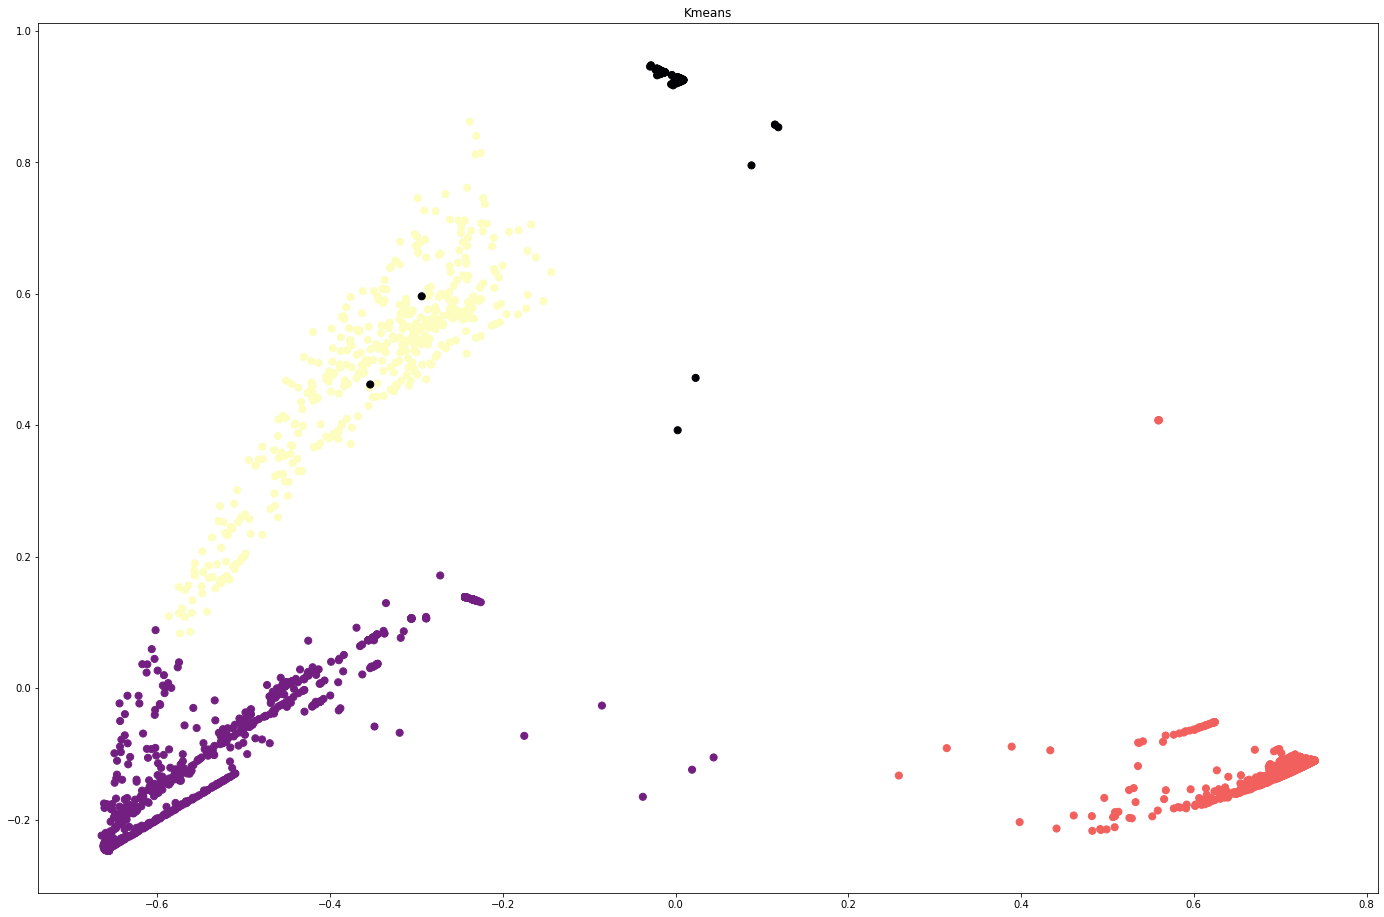

In [75]:
kmeans = KMeans(n_clusters=4, random_state=180, max_iter=400, n_init=4, init='k-means++', algorithm='elkan').fit(train_data_norm)
print("Mutual_info:", metrics.adjusted_mutual_info_score(kmeans.labels_, train_label.values[:, -1]))

plt.figure(figsize=(24,16))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='magma')
plt.title('Kmeans')

Text(0.5, 1.0, 'Kmeans')

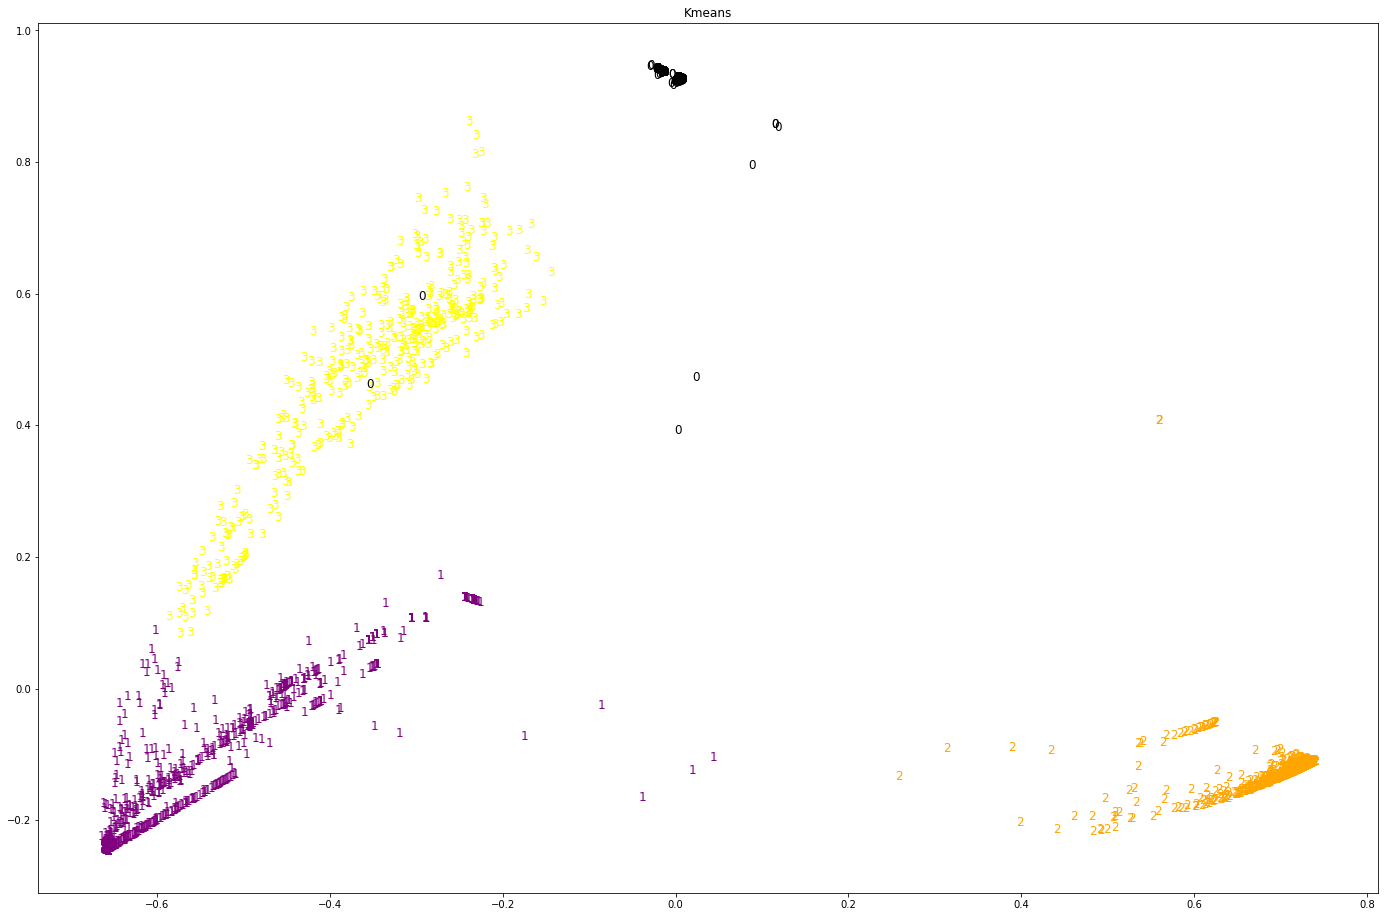

In [76]:
cmap = ['black', 'purple', 'orange', 'yellow']

plt.figure(figsize=(24,16))
pred_label = kmeans.labels_

for i, xy in enumerate(res):
    plt.text(xy[0], xy[1], str(pred_label[i]), fontsize=12, 
             c=cmap[pred_label[i]], ha="center", va="center")

plt.scatter(res[:,0], res[:,1], alpha=0) 
plt.title('Kmeans')